## Classification Model for Gender prediction

The following notebook is a full end to end model development, testing and export to predict the gender of a user based on the transactions that they have made throughout the year

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle

In [126]:
#import 
data = pd.read_csv('gender-prediction.csv')


### Data Exploration

In this phase, we are exploring the data along with performing cleaning and feature engineering

In [127]:
#check unique users
data['user_id'].nunique()

1200

In [128]:
data['date'] = pd.to_datetime(data['date'])
data['week_date'] = data['date'].dt.to_period('W').apply(lambda r: r.start_time)
#data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_week'] = data['date'].dt.day_name()
data['month_name'] = data['date'].dt.month_name()
# Create a new column 'amount_absolute' that is the absolute value of 'amount'
data['amount_absolute'] = data['amount'].abs()
data = data[data['amount'] != 0]
data

,user_id,description,category,amount,date,gender,week_date,day_of_week,month_name,amount_absolute
0,2415848187644231731,-,Babysitter & Daycare,-105.70,2016-12-02,M,2016-11-28,Friday,December,105.70
1,2415848187644231731,-,Transfer,-712.31,2016-12-02,M,2016-11-28,Friday,December,712.31
2,7621821633626091160,-,Finance Charge,-2.02,2016-12-02,M,2016-11-28,Friday,December,2.02
3,2215014179620581716,-,Parking,-5.20,2016-12-02,F,2016-11-28,Friday,December,5.20
4,906409546992525081,CVS,Pharmacy,-14.13,2016-12-02,M,2016-11-28,Friday,December,14.13
...,...,...,...,...,...,...,...,...,...,...
999995,3893022692252848354,-,Uncategorized,-29.63,2016-09-12,F,2016-09-12,Monday,September,29.63
999996,122335106798477998,Trader Joe's,Groceries,-155.51,2016-09-12,M,2016-09-12,Monday,September,155.51
999997,8148581929230453446,Cost Plus World Market,Furnishings,-47.59,2016-09-12,F,2016-09-12,Monday,September,47.59
999998,6011148609381392415,Sam's Club,Shopping,-31.37,2016-09-12,M,2016-09-12,Monday,September,31.37


In [129]:
# Find all duplicates based on 'user_id', 'description', 'category', 'date', 'gender', 'amount_absolute'
duplicates = data[data.duplicated(subset=['user_id', 'description', 'category', 'date', 'gender', 'amount_absolute'], keep=False)]

# Filter the duplicates where 'amount' is different
duplicates_diff_amount = duplicates[duplicates.duplicated(subset=['amount'], keep=False) == False]

duplicates_diff_amount

,user_id,description,category,amount,date,gender,week_date,day_of_week,month_name,amount_absolute
137,7509266289574629864,-,Transfer,24.07,2016-12-02,F,2016-11-28,Friday,December,24.07
139,356860948890960020,-,Credit Card Payment,-1990.11,2016-12-02,M,2016-11-28,Friday,December,1990.11
290,4234648200698629684,-,Credit Card Payment,-380.24,2016-12-02,M,2016-11-28,Friday,December,380.24
380,3961284535501673590,-,Transfer,-2312.50,2016-12-01,M,2016-11-28,Thursday,December,2312.50
550,3269394844600395996,-,Transfer,-688.50,2016-12-01,F,2016-11-28,Thursday,December,688.50
...,...,...,...,...,...,...,...,...,...,...
999611,8216401772756056681,-,Uncategorized,391.13,2016-10-28,F,2016-10-24,Friday,October,391.13
999669,3888587295219844821,-,Credit Card Payment,150.08,2016-10-31,M,2016-10-31,Monday,October,150.08
999851,8216401772756056681,-,Uncategorized,1072.10,2016-09-28,F,2016-09-26,Wednesday,September,1072.10
999865,356860948890960020,-,Credit Card Payment,2723.00,2016-09-01,M,2016-08-29,Thursday,September,2723.00


In [130]:
# Remove the rows in 'data' that are in 'duplicates_diff_amount'
data_clean = data.drop(duplicates_diff_amount.index)
data_clean

,user_id,description,category,amount,date,gender,week_date,day_of_week,month_name,amount_absolute
0,2415848187644231731,-,Babysitter & Daycare,-105.70,2016-12-02,M,2016-11-28,Friday,December,105.70
1,2415848187644231731,-,Transfer,-712.31,2016-12-02,M,2016-11-28,Friday,December,712.31
2,7621821633626091160,-,Finance Charge,-2.02,2016-12-02,M,2016-11-28,Friday,December,2.02
3,2215014179620581716,-,Parking,-5.20,2016-12-02,F,2016-11-28,Friday,December,5.20
4,906409546992525081,CVS,Pharmacy,-14.13,2016-12-02,M,2016-11-28,Friday,December,14.13
...,...,...,...,...,...,...,...,...,...,...
999995,3893022692252848354,-,Uncategorized,-29.63,2016-09-12,F,2016-09-12,Monday,September,29.63
999996,122335106798477998,Trader Joe's,Groceries,-155.51,2016-09-12,M,2016-09-12,Monday,September,155.51
999997,8148581929230453446,Cost Plus World Market,Furnishings,-47.59,2016-09-12,F,2016-09-12,Monday,September,47.59
999998,6011148609381392415,Sam's Club,Shopping,-31.37,2016-09-12,M,2016-09-12,Monday,September,31.37


In [131]:
# Find duplicates
duplicates = data[data.duplicated(subset=['user_id', 'category', 'description', 'amount', 'date', 'gender'], keep=False)]

In [132]:
data=data_clean

In [133]:
#unique users per gender
unique_users = data.drop_duplicates(subset=['user_id', 'gender']).groupby('gender')['user_id'].nunique()

print(unique_users)

gender
F    575
M    625
Name: user_id, dtype: int64


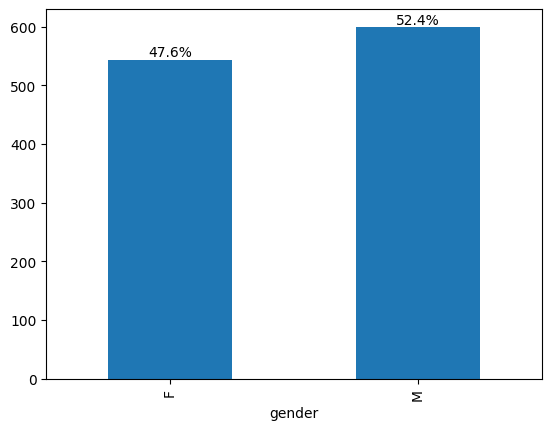

In [134]:
# Filter the DataFrame for 'category' equal to 'Uncategorised'
uncategorised_data = data[data['category'] == 'Uncategorized']

# Calculate the number of unique 'user_id's for each 'gender'
unique_users_uncategorised = uncategorised_data.groupby('gender')['user_id'].nunique()

if not unique_users_uncategorised.empty:
    # Calculate the proportion of unique 'user_id's for each 'gender'
    user_proportions_uncategorised = unique_users_uncategorised / unique_users_uncategorised.sum()

    # Plot the counts in a bar chart
    ax = unique_users_uncategorised.plot(kind='bar')

    # Add the proportions as text to the bars
    for i, value in enumerate(unique_users_uncategorised):
        ax.text(i, value, f'{user_proportions_uncategorised[i]*100:.1f}%', ha='center', va='bottom')

    plt.show()
else:
    print("No data to plot")

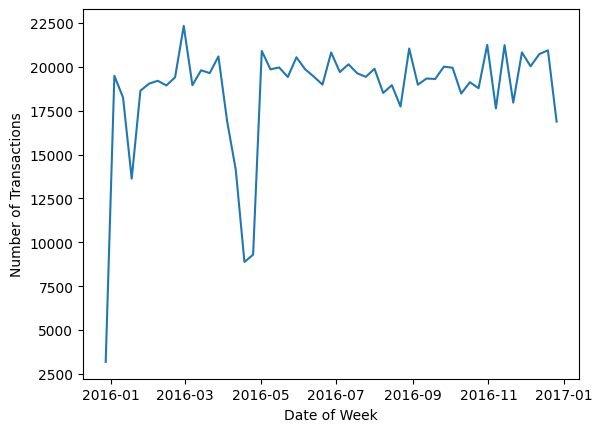

In [135]:


trans = data.groupby('week_date').size().reset_index(name='number_of_transactions')

# Capture the axes object returned by lineplot
ax = sns.lineplot(data=trans, x='week_date', y='number_of_transactions')

# Now you can set the labels
ax.set_xlabel('Date of Week')
ax.set_ylabel('Number of Transactions')

plt.show()

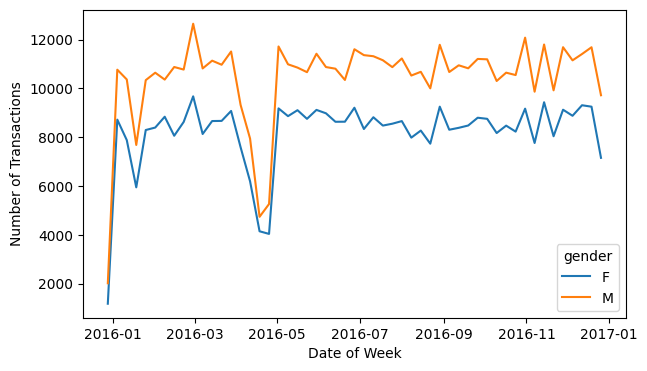

In [136]:
# Set the figure size
plt.figure(figsize=[7, 4])  # Here, the width is 8 and the height is 6, so the height is 3/4 of the width

trans = data.groupby(['week_date', 'gender']).size().reset_index(name='number_of_transactions')

# Capture the axes object returned by lineplot
ax = sns.lineplot(data=trans, x='week_date', y='number_of_transactions', hue='gender')

# Now you can set the labels
ax.set_xlabel('Date of Week')
ax.set_ylabel('Number of Transactions')

plt.show()

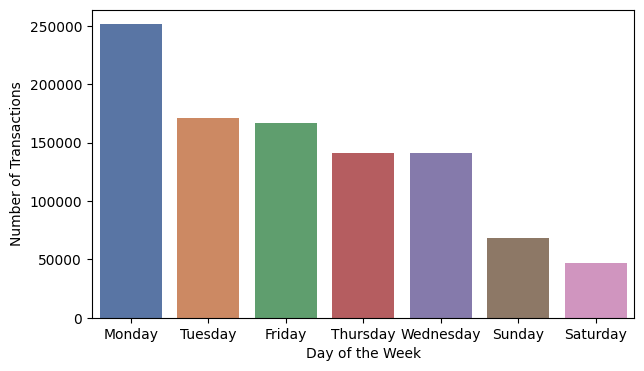

In [137]:
plt.figure(figsize=[7, 4]) 
# Create a DataFrame that contains 'day_of_week' and 'number_of_transactions'
trans = data.groupby('day_of_week').size().reset_index(name='number_of_transactions')

# Sort the DataFrame by 'number_of_transactions' in descending order
trans = trans.sort_values('number_of_transactions', ascending=False)

# Create a bar plot with 'day_of_week' on the x-axis and 'number_of_transactions' on the y-axis
ax=sns.barplot(data=trans, x='day_of_week', y='number_of_transactions',palette="deep")

# Now you can set the labels
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Number of Transactions')
plt.show()

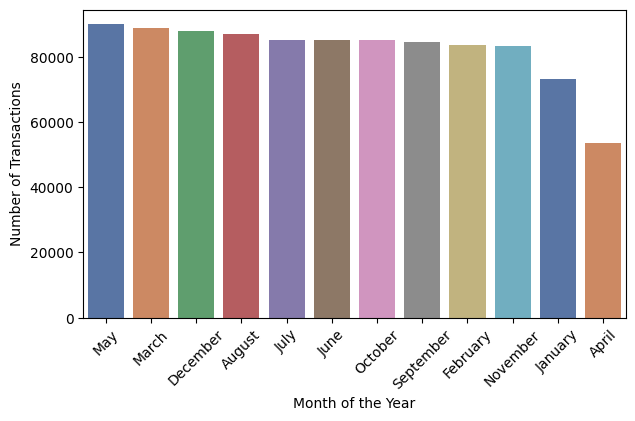

In [138]:
plt.figure(figsize=[7, 4]) 
# Create a DataFrame that contains 'day_of_week' and 'number_of_transactions'
trans = data.groupby('month_name').size().reset_index(name='number_of_transactions')

# Sort the DataFrame by 'number_of_transactions' in descending order
trans = trans.sort_values('number_of_transactions', ascending=False)

# Create a bar plot with 'day_of_week' on the x-axis and 'number_of_transactions' on the y-axis
# Remove the color parameter to use all the colors in the seaborn palette
ax=sns.barplot(data=trans, x='month_name', y='number_of_transactions', palette="deep")

# Now you can set the labels
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Number of Transactions')

plt.xticks(rotation=45)
plt.show()

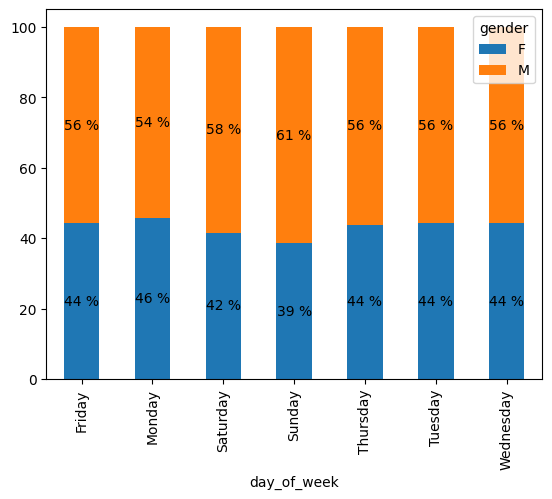

In [139]:
# Create a DataFrame that contains 'day_of_week', 'gender', and 'number_of_transactions'
trans = data.groupby(['day_of_week', 'gender']).size().reset_index(name='number_of_transactions')

# Sort the DataFrame by 'day_of_week' in descending order
trans = trans.sort_values('day_of_week', ascending=False)

# Pivot the DataFrame to have 'day_of_week' as index, 'gender' as columns, and 'number_of_transactions' as values
trans_pivot = trans.pivot(index='day_of_week', columns='gender', values='number_of_transactions')

# Calculate the percentages
trans_percent = trans_pivot.divide(trans_pivot.sum(axis=1), axis=0) * 100

# Create a stacked bar plot
ax = trans_percent.plot(kind='bar', stacked=True)

# Add the percentages to the plot
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

plt.show()

<Figure size 700x400 with 0 Axes>

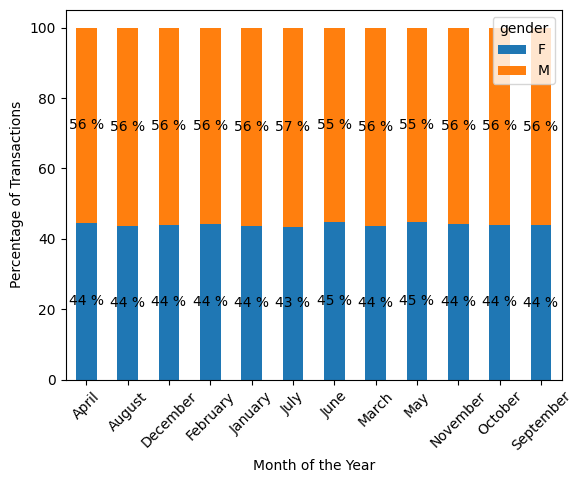

In [140]:
# Set the figure size
plt.figure(figsize=[7, 4])

# Create a DataFrame that contains 'month_of_year', 'gender', and 'number_of_transactions'
trans = data.groupby(['month_name', 'gender']).size().reset_index(name='number_of_transactions')

# Sort the DataFrame by 'month_of_year' in descending order
trans = trans.sort_values('month_name', ascending=False)

# Pivot the DataFrame to have 'month_of_year' as index, 'gender' as columns, and 'number_of_transactions' as values
trans_pivot = trans.pivot(index='month_name', columns='gender', values='number_of_transactions')

# Calculate the percentages
trans_percent = trans_pivot.divide(trans_pivot.sum(axis=1), axis=0) * 100

# Create a stacked bar plot
ax = trans_percent.plot(kind='bar', stacked=True)

# Add the percentages to the plot
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

# Set the axis labels
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Percentage of Transactions')

plt.show()

<Figure size 700x400 with 0 Axes>

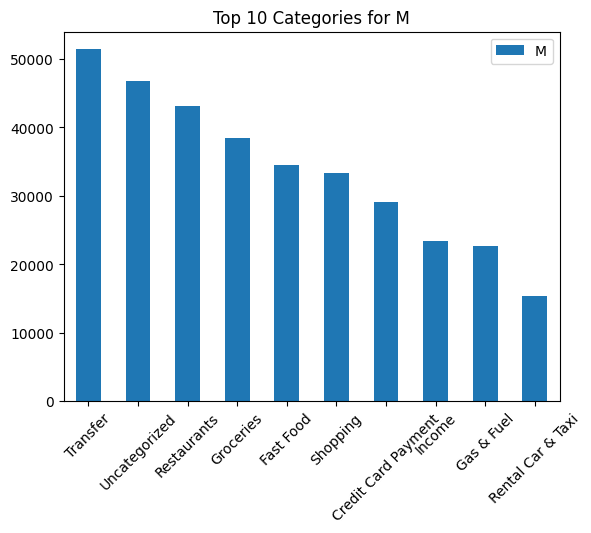

<Figure size 700x400 with 0 Axes>

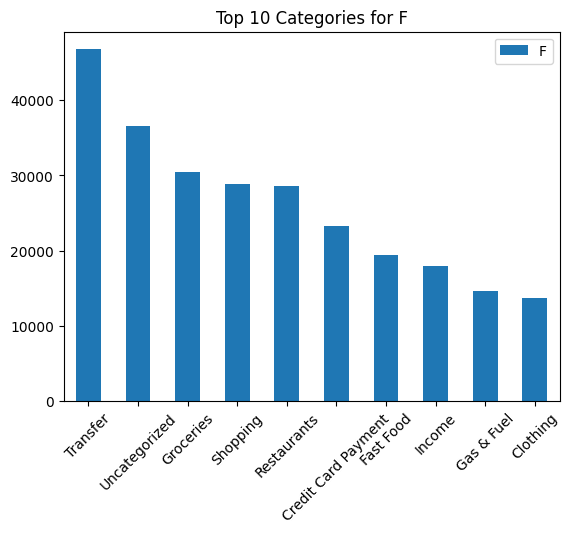

In [141]:
# Create two DataFrames
data_M = data[data['gender'] == 'M']
data_F = data[data['gender'] == 'F']

# Get the value counts for 'category' for each DataFrame
category_counts_M = data_M['category'].value_counts()
category_counts_F = data_F['category'].value_counts()

# Get the top 10 categories for each DataFrame
top_10_categories_M = category_counts_M.nlargest(10)
top_10_categories_F = category_counts_F.nlargest(10)

# Create a DataFrame from the top 10 categories
df_M = pd.DataFrame({'M': top_10_categories_M})
df_F = pd.DataFrame({'F': top_10_categories_F})

# Set the figure size
plt.figure(figsize=[7, 4])

# Create a bar plot for 'M'
df_M.plot(kind='bar', title='Top 10 Categories for M')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

plt.show()

# Set the figure size
plt.figure(figsize=[7, 4])

# Create a bar plot for 'F'
df_F.plot(kind='bar', title='Top 10 Categories for F')

# Rotate the x-axis labels to 45 degrees
plt.xticks(rotation=45)

plt.show()

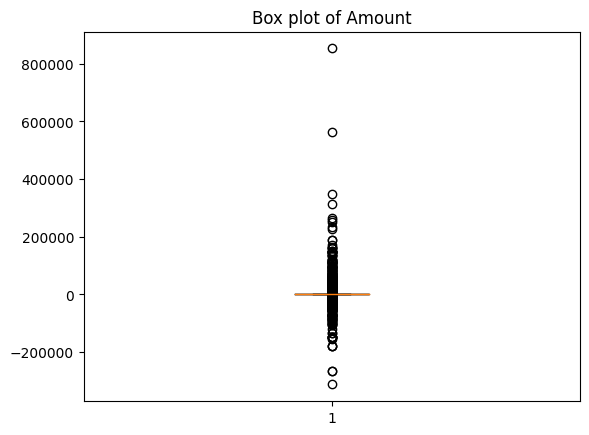

In [142]:
plt.boxplot(data['amount'])
plt.title('Box plot of Amount')
plt.show()

In [143]:
# Filter the data, sort it in descending order, and display the top 30 rows
data[data['amount']>0].sort_values(by='amount', ascending=False).head(30)

,user_id,description,category,amount,date,gender,week_date,day_of_week,month_name,amount_absolute
838864,4822591333790581453,-,Income,852640.00,2016-03-01,F,2016-02-29,Tuesday,March,852640.00
238523,8305088074128008174,-,Income,562600.00,2016-10-19,M,2016-10-17,Wednesday,October,562600.00
544970,1665326792200404084,-,Income,347169.44,2016-07-13,M,2016-07-11,Wednesday,July,347169.44
811379,2415848187644231731,-,Income,312149.65,2016-01-14,M,2016-01-11,Thursday,January,312149.65
67810,4437069338373463240,-,Transfer,265000.00,2016-11-22,M,2016-11-21,Tuesday,November,265000.00
473409,4437069338373463240,-,Transfer,257950.00,2016-07-13,M,2016-07-11,Wednesday,July,257950.00
762093,3489919281593463838,-,Credit Card Payment,252000.00,2016-01-21,M,2016-01-18,Thursday,January,252000.00
473784,4278193632566777163,-,Income,234964.79,2016-07-14,M,2016-07-11,Thursday,July,234964.79
639303,3517936276244269991,-,Income,228166.10,2016-05-18,M,2016-05-16,Wednesday,May,228166.10
505402,3517936276244269991,-,Income,187970.17,2016-07-11,M,2016-07-11,Monday,July,187970.17


<Axes: xlabel='amount'>

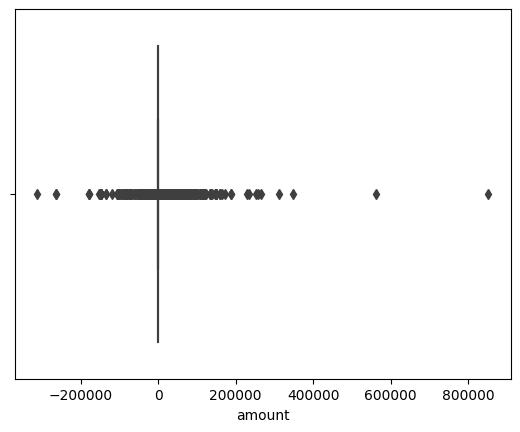

In [144]:
sns.boxplot(x=data['amount'])

In [145]:
data=data_clean

In [146]:
# Filter the data for cases where 'amount' is less than 200000 and greater than -200000
data = data[(data['amount'] <= 200000) & (data['amount'] >= -200000)]

data

,user_id,description,category,amount,date,gender,week_date,day_of_week,month_name,amount_absolute
0,2415848187644231731,-,Babysitter & Daycare,-105.70,2016-12-02,M,2016-11-28,Friday,December,105.70
1,2415848187644231731,-,Transfer,-712.31,2016-12-02,M,2016-11-28,Friday,December,712.31
2,7621821633626091160,-,Finance Charge,-2.02,2016-12-02,M,2016-11-28,Friday,December,2.02
3,2215014179620581716,-,Parking,-5.20,2016-12-02,F,2016-11-28,Friday,December,5.20
4,906409546992525081,CVS,Pharmacy,-14.13,2016-12-02,M,2016-11-28,Friday,December,14.13
...,...,...,...,...,...,...,...,...,...,...
999995,3893022692252848354,-,Uncategorized,-29.63,2016-09-12,F,2016-09-12,Monday,September,29.63
999996,122335106798477998,Trader Joe's,Groceries,-155.51,2016-09-12,M,2016-09-12,Monday,September,155.51
999997,8148581929230453446,Cost Plus World Market,Furnishings,-47.59,2016-09-12,F,2016-09-12,Monday,September,47.59
999998,6011148609381392415,Sam's Club,Shopping,-31.37,2016-09-12,M,2016-09-12,Monday,September,31.37


In [147]:
# Drop 'description' and 'week_date'
data_ohe = data[['user_id','category', 'day_of_week','month_name']]

# One-hot encode 'category' and 'day_of_week'
data_ohe = pd.get_dummies(data_ohe, columns=['category', 'day_of_week','month_name'])

aggregated_data_ohe = data_ohe.groupby('user_id').sum().reset_index()
aggregated_data_ohe

,user_id,category_ATM Fee,category_Advertising,category_Air Travel,category_Alcohol & Bars,category_Allowance,category_Amusement,category_Arts,category_Auto & Transport,category_Auto Insurance,...,month_name_December,month_name_February,month_name_January,month_name_July,month_name_June,month_name_March,month_name_May,month_name_November,month_name_October,month_name_September
0,19306846752703627,0,0,0,7,0,0,4,0,0,...,70,31,18,33,28,35,40,92,75,111
1,29999460353675555,0,0,4,5,0,0,2,3,1,...,117,126,89,88,97,98,102,98,145,76
2,30320811342650176,7,4,13,59,0,1,0,6,14,...,382,115,129,197,144,133,134,322,331,254
3,38670402761689682,0,0,1,1,0,0,0,0,2,...,0,67,85,0,0,127,129,0,0,0
4,49501698316876721,5,4,10,66,0,7,2,6,0,...,136,95,103,141,162,198,129,160,128,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,9163946498474024353,0,0,0,0,0,0,0,0,0,...,61,42,53,57,65,68,45,52,57,55
1196,9167458092879270697,11,2,12,70,0,1,1,1,23,...,98,141,109,104,103,109,124,116,121,139
1197,9176574324640558886,13,0,0,37,0,0,0,1,8,...,70,30,28,79,77,30,80,41,93,79
1198,9178949703060226873,2,0,0,63,0,4,0,0,1,...,73,93,90,59,62,84,69,57,78,81


In [148]:
data_rest=data[['user_id','amount','amount_absolute','date','gender']]
data_rest


,user_id,amount,amount_absolute,date,gender
0,2415848187644231731,-105.70,105.70,2016-12-02,M
1,2415848187644231731,-712.31,712.31,2016-12-02,M
2,7621821633626091160,-2.02,2.02,2016-12-02,M
3,2215014179620581716,-5.20,5.20,2016-12-02,F
4,906409546992525081,-14.13,14.13,2016-12-02,M
...,...,...,...,...,...
999995,3893022692252848354,-29.63,29.63,2016-09-12,F
999996,122335106798477998,-155.51,155.51,2016-09-12,M
999997,8148581929230453446,-47.59,47.59,2016-09-12,F
999998,6011148609381392415,-31.37,31.37,2016-09-12,M


In [149]:
aggregated_data_rest = data_rest.groupby(['user_id', 'gender']).agg(
    number_of_transactions=('user_id', 'count'),
    total_amount=('amount', 'sum'),
    total_amount_absolute=('amount_absolute', 'sum'),
    average_amount=('amount_absolute', 'mean'),
    min_date=('date', 'min'),
    max_date=('date', 'max')
).reset_index()

aggregated_data_rest['total_days'] = (aggregated_data_rest['max_date'] - aggregated_data_rest['min_date']).dt.days
aggregated_data_rest

,user_id,gender,number_of_transactions,total_amount,total_amount_absolute,average_amount,min_date,max_date,total_days
0,19306846752703627,F,623,3941.18,86409.58,138.699165,2016-01-04,2016-12-30,361
1,29999460353675555,M,1199,-29689.77,430205.17,358.803311,2016-01-01,2016-12-30,364
2,30320811342650176,F,2529,37625.97,383650.59,151.700510,2016-01-04,2016-12-31,362
3,38670402761689682,M,504,9343.76,90635.86,179.833056,2016-01-01,2016-05-26,146
4,49501698316876721,M,1628,-29495.01,313967.33,192.854625,2016-01-01,2016-12-30,364
...,...,...,...,...,...,...,...,...,...
1195,9163946498474024353,F,639,19499.38,207887.26,325.332175,2016-01-02,2016-12-31,364
1196,9167458092879270697,M,1332,18639.50,177957.58,133.601787,2016-01-01,2016-12-31,365
1197,9176574324640558886,M,719,5607.70,51370.58,71.447260,2016-01-04,2016-12-30,361
1198,9178949703060226873,M,871,-12759.56,144742.22,166.179357,2016-01-04,2016-12-30,361


In [150]:
grouped_data = aggregated_data_rest.groupby('gender')[['number_of_transactions', 'total_amount','total_amount_absolute']].sum()

print(grouped_data)

        number_of_transactions  total_amount  total_amount_absolute
gender                                                             
F                       434526     388971.24           7.613405e+07
M                       552234     367711.30           1.313297e+08


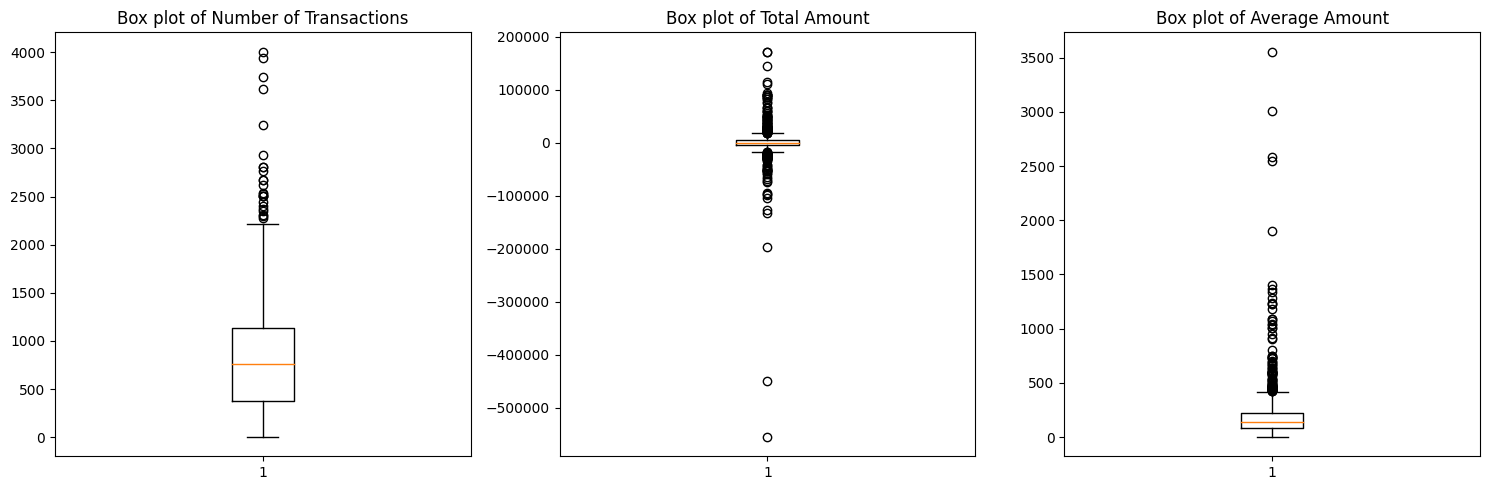

In [151]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(aggregated_data_rest['number_of_transactions'])
plt.title('Box plot of Number of Transactions')

plt.subplot(1, 3, 2)
plt.boxplot(aggregated_data_rest['total_amount'])
plt.title('Box plot of Total Amount')

plt.subplot(1, 3, 3)
plt.boxplot(aggregated_data_rest['average_amount'])
plt.title('Box plot of Average Amount')

plt.tight_layout()
plt.show()

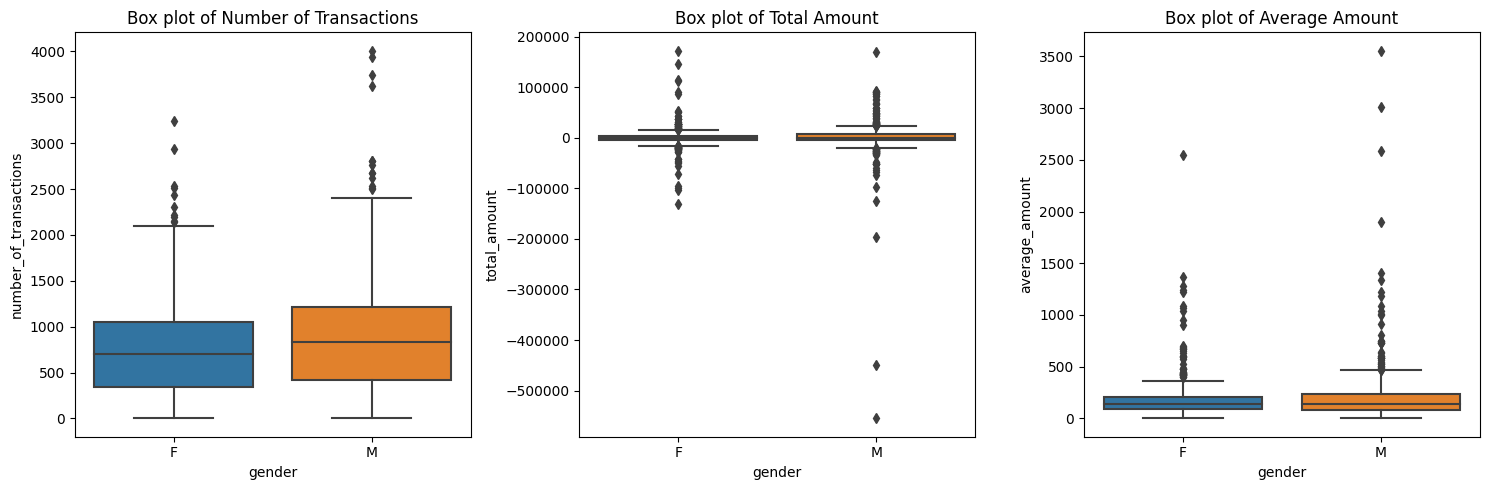

In [152]:
import seaborn as sns

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='gender', y='number_of_transactions', data=aggregated_data_rest)
plt.title('Box plot of Number of Transactions')

plt.subplot(1, 3, 2)
sns.boxplot(x='gender', y='total_amount', data=aggregated_data_rest)
plt.title('Box plot of Total Amount')

plt.subplot(1, 3, 3)
sns.boxplot(x='gender', y='average_amount', data=aggregated_data_rest)
plt.title('Box plot of Average Amount')

plt.tight_layout()
plt.show()

In [153]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces for each gender
for gender in aggregated_data_rest['gender'].unique():
    df_gender = aggregated_data_rest[aggregated_data_rest['gender'] == gender]
    fig.add_trace(go.Scatter(x=df_gender['number_of_transactions'], 
                             y=df_gender['total_amount'], 
                             mode='markers', 
                             name=gender))

fig.update_layout(title='Scatter plot of Number of Transactions vs Average Amount',
                  xaxis_title='Number of Transactions',
                  yaxis_title='Average Amount')

fig.show()

In [154]:
aggregated_data_rest.describe()

,user_id,number_of_transactions,total_amount,total_amount_absolute,average_amount,total_days
count,1.200000e+03,1200.000000,1200.000000,1.200000e+03,1200.000000,1200.000000
mean,4.603882e+18,822.300000,630.568783,1.728865e+05,194.723388,305.926667
std,2.643875e+18,586.007779,29682.057330,4.205290e+05,240.212150,101.877576
min,1.930685e+16,1.000000,-554698.460000,7.000000e-02,0.010000,0.000000
25%,2.339974e+18,376.000000,-4230.265000,4.298026e+04,86.286201,291.750000
50%,4.552777e+18,759.500000,32.310000,1.018584e+05,138.723054,361.000000
75%,6.818285e+18,1136.250000,4960.837500,1.958762e+05,219.306030,364.000000
max,9.221480e+18,4007.000000,171969.290000,1.034429e+07,3555.437277,365.000000


In [155]:
merged_data = aggregated_data_rest.merge(aggregated_data_ohe, on='user_id')

In [156]:
merged_data

,user_id,gender,number_of_transactions,total_amount,total_amount_absolute,average_amount,min_date,max_date,total_days,category_ATM Fee,...,month_name_December,month_name_February,month_name_January,month_name_July,month_name_June,month_name_March,month_name_May,month_name_November,month_name_October,month_name_September
0,19306846752703627,F,623,3941.18,86409.58,138.699165,2016-01-04,2016-12-30,361,0,...,70,31,18,33,28,35,40,92,75,111
1,29999460353675555,M,1199,-29689.77,430205.17,358.803311,2016-01-01,2016-12-30,364,0,...,117,126,89,88,97,98,102,98,145,76
2,30320811342650176,F,2529,37625.97,383650.59,151.700510,2016-01-04,2016-12-31,362,7,...,382,115,129,197,144,133,134,322,331,254
3,38670402761689682,M,504,9343.76,90635.86,179.833056,2016-01-01,2016-05-26,146,0,...,0,67,85,0,0,127,129,0,0,0
4,49501698316876721,M,1628,-29495.01,313967.33,192.854625,2016-01-01,2016-12-30,364,5,...,136,95,103,141,162,198,129,160,128,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,9163946498474024353,F,639,19499.38,207887.26,325.332175,2016-01-02,2016-12-31,364,0,...,61,42,53,57,65,68,45,52,57,55
1196,9167458092879270697,M,1332,18639.50,177957.58,133.601787,2016-01-01,2016-12-31,365,11,...,98,141,109,104,103,109,124,116,121,139
1197,9176574324640558886,M,719,5607.70,51370.58,71.447260,2016-01-04,2016-12-30,361,13,...,70,30,28,79,77,30,80,41,93,79
1198,9178949703060226873,M,871,-12759.56,144742.22,166.179357,2016-01-04,2016-12-30,361,2,...,73,93,90,59,62,84,69,57,78,81


## Modelling 

## Logisitc Regression

In [157]:
modelling_data=merged_data
modelling_data = modelling_data.drop(['user_id', 'min_date', 'max_date'], axis=1)
modelling_data['gender'] = modelling_data['gender'].replace({'F': 1, 'M': 0})
modelling_data


,gender,number_of_transactions,total_amount,total_amount_absolute,average_amount,total_days,category_ATM Fee,category_Advertising,category_Air Travel,category_Alcohol & Bars,...,month_name_December,month_name_February,month_name_January,month_name_July,month_name_June,month_name_March,month_name_May,month_name_November,month_name_October,month_name_September
0,1,623,3941.18,86409.58,138.699165,361,0,0,0,7,...,70,31,18,33,28,35,40,92,75,111
1,0,1199,-29689.77,430205.17,358.803311,364,0,0,4,5,...,117,126,89,88,97,98,102,98,145,76
2,1,2529,37625.97,383650.59,151.700510,362,7,4,13,59,...,382,115,129,197,144,133,134,322,331,254
3,0,504,9343.76,90635.86,179.833056,146,0,0,1,1,...,0,67,85,0,0,127,129,0,0,0
4,0,1628,-29495.01,313967.33,192.854625,364,5,4,10,66,...,136,95,103,141,162,198,129,160,128,135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1,639,19499.38,207887.26,325.332175,364,0,0,0,0,...,61,42,53,57,65,68,45,52,57,55
1196,0,1332,18639.50,177957.58,133.601787,365,11,2,12,70,...,98,141,109,104,103,109,124,116,121,139
1197,0,719,5607.70,51370.58,71.447260,361,13,0,0,37,...,70,30,28,79,77,30,80,41,93,79
1198,0,871,-12759.56,144742.22,166.179357,361,2,0,0,63,...,73,93,90,59,62,84,69,57,78,81


In [158]:
# Calculate the correlation matrix
corr_matrix = modelling_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
modelling_data_dropped = modelling_data.drop(modelling_data[to_drop], axis=1)

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming 'gender' is your target variable
X = modelling_data.drop('gender', axis=1)
#X = modelling_data.drop('gender', axis=1).values
y = modelling_data['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42,stratify=y)

In [160]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(max_iter=1000, random_state=42)

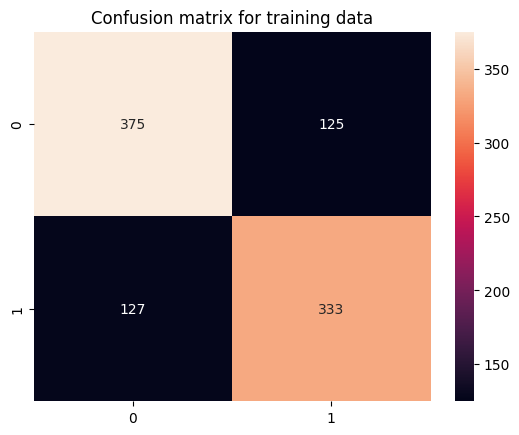

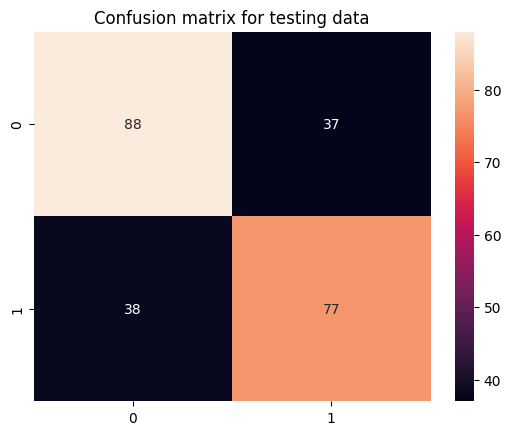

In [161]:


# Predictions for training data
y_train_pred = log_reg.predict(X_train)

# Confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)

# Visualize confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='d')
plt.title('Confusion matrix for training data')
plt.show()

# Predictions for testing data
y_test_pred = log_reg.predict(X_test)

# Confusion matrix for testing data
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualize confusion matrix for testing data
sns.heatmap(cm_test, annot=True, fmt='d')
plt.title('Confusion matrix for testing data')
plt.show()

In [162]:
from sklearn.metrics import classification_report

# Assuming best_rf_model is your trained RandomForestClassifier
# And X_train, y_train, X_test, y_test are your data

# Predict the classes for the training and test sets
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Get the classification report for the training set
train_report = classification_report(y_train, y_train_pred)

# Get the classification report for the test set
test_report = classification_report(y_test, y_test_pred)

print("Training set metrics:\n", train_report)
print("Test set metrics:\n", test_report)

Training set metrics:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       500
           1       0.73      0.72      0.73       460

    accuracy                           0.74       960
   macro avg       0.74      0.74      0.74       960
weighted avg       0.74      0.74      0.74       960

Test set metrics:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70       125
           1       0.68      0.67      0.67       115

    accuracy                           0.69       240
   macro avg       0.69      0.69      0.69       240
weighted avg       0.69      0.69      0.69       240



## SGD Classifier

In [163]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [164]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="roc_auc",)


array([0.41513052, 0.45512896, 0.4363167 ])

In [165]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                             method="decision_function")


In [166]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


In [167]:


# Assuming best_rf_model is your trained RandomForestClassifier
# And X_train, y_train, X_test, y_test are your data

# Predict the classes for the training and test sets
y_train_pred = sgd_clf.predict(X_train)
y_test_pred = sgd_clf.predict(X_test)

# Get the classification report for the training set
train_report = classification_report(y_train, y_train_pred)

# Get the classification report for the test set
test_report = classification_report(y_test, y_test_pred)

print("Training set metrics:\n", train_report)
print("Test set metrics:\n", test_report)

Training set metrics:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68       500
           1       0.25      0.00      0.01       460

    accuracy                           0.52       960
   macro avg       0.38      0.50      0.34       960
weighted avg       0.39      0.52      0.36       960

Test set metrics:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68       125
           1       0.00      0.00      0.00       115

    accuracy                           0.52       240
   macro avg       0.26      0.50      0.34       240
weighted avg       0.27      0.52      0.35       240



## Naive Bayes

In [168]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [169]:

y_pred = nb.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.6
F1 Score: 0.6311111111111111


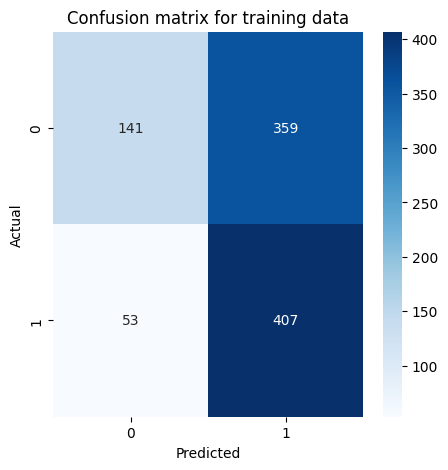

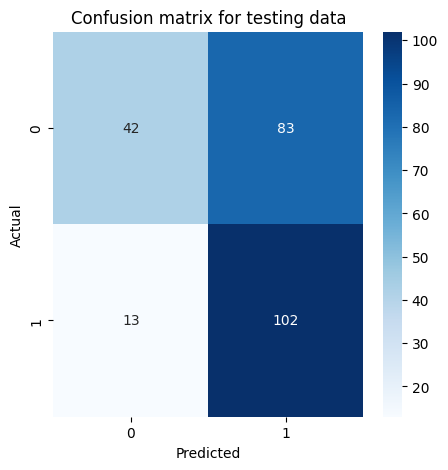

In [170]:


# Predict the classes for both training and testing data
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

## Decision Trees Classifier

In [171]:


dtc = DecisionTreeClassifier(max_depth=1,random_state=42)
dtc.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=1, random_state=42)

In [172]:


y_pred = dtc.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.6291666666666667
F1 Score: 0.6311094951902018


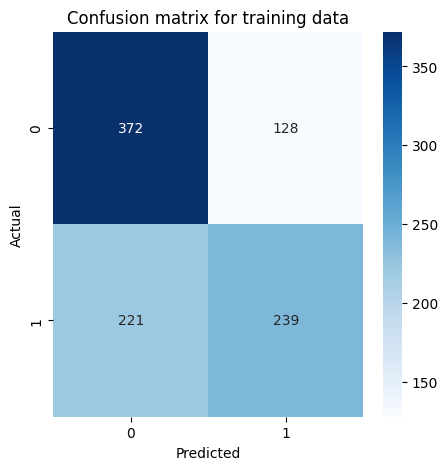

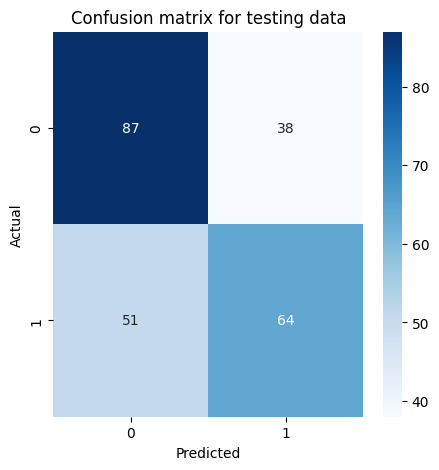

In [173]:


# Predict the classes for both training and testing data
y_train_pred = dtc.predict(X_train)
y_test_pred = dtc.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

## Random Forrest Classifier

In [174]:


rfc = RandomForestClassifier(max_depth=2,random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=42)

In [175]:


y_pred = rfc.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.75
F1 Score: 0.7553571428571427


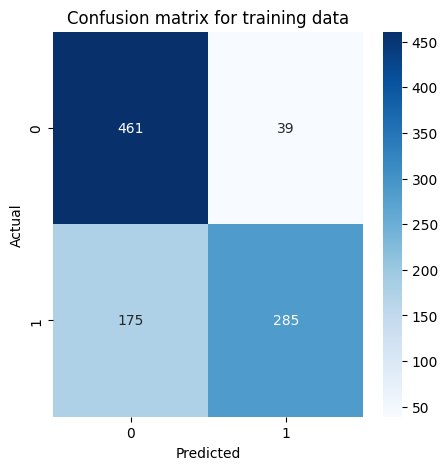

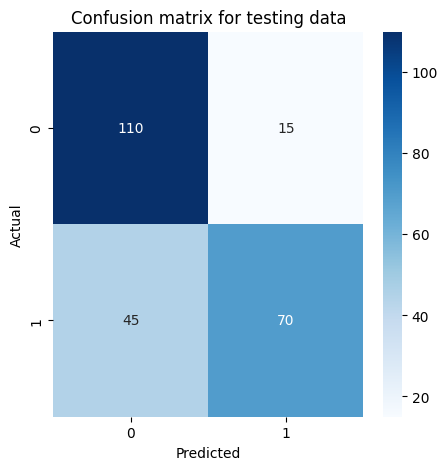

In [176]:


# Predict the classes for both training and testing data
y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

## XGB 

In [177]:


# Instantiate the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the XGBClassifier to the training data
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [178]:

y_pred = xgb.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.8
F1 Score: 0.8001951083548186


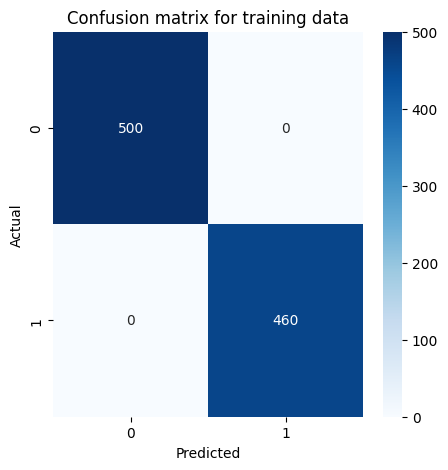

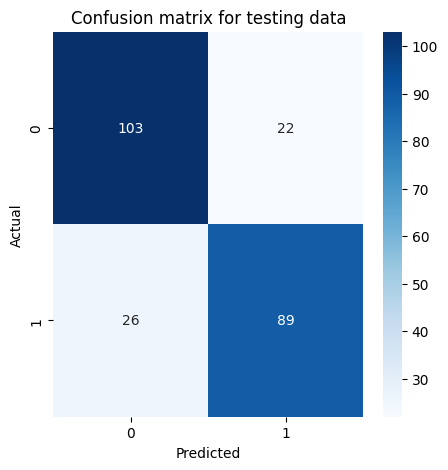

In [179]:


# Predict the classes for both training and testing data
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

## Ada boost (Ensemble Learning)

In [180]:


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=50,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, random_state=42)

In [181]:


y_pred = ada_clf.predict(X_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.8125
F1 Score: 0.8127450980392157


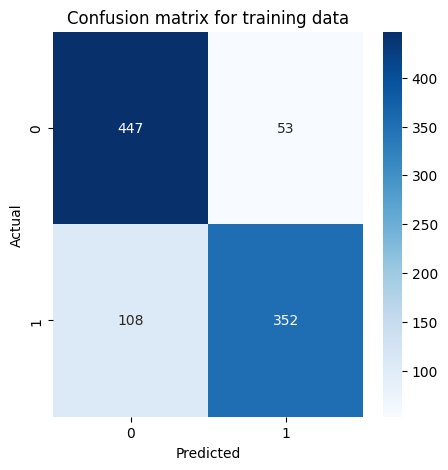

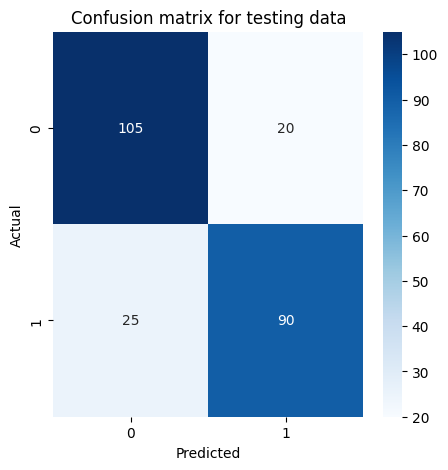

In [182]:


# Predict the classes for both training and testing data
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

## Neural Network

In [183]:
import pandas as pd
import tensorflow as tf

# Sample DataFrame
data = {
    'feature1': [1, 2, 3, 4],
    'feature2': [5, 6, 7, 8],
    'target': [0, 1, 0, 1]
}
df = pd.DataFrame(data)

# Separate features and labels
X = df.drop('target', axis=1)
y = df['target']

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))

# Shuffle and batch the dataset
batch_size = 3
dataset = dataset.shuffle(buffer_size=len(df)).batch(batch_size)

# Check the dataset
for features, labels in dataset:
    print(features.numpy(), labels.numpy())

[[1 5]
 [4 8]
 [3 7]] [0 1 0]
[[2 6]] [1]


In [184]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [185]:
batch_size = 50
dataset_train = dataset_train.shuffle(buffer_size=len(dataset_train)).batch(batch_size)

# Check the dataset
for features, labels in dataset_train:
    print(features.numpy(), labels.numpy())

[[ 4.5000000e+02 -5.7034700e+03  5.1004330e+04 ...  2.9000000e+01
   4.0000000e+01  2.4000000e+01]
 [ 1.2870000e+03  1.4212800e+03  1.1743530e+05 ...  1.1500000e+02
   9.7000000e+01  1.2700000e+02]
 [ 5.2300000e+02  7.9527700e+03  6.3734090e+04 ...  5.2000000e+01
   4.2000000e+01  4.3000000e+01]
 ...
 [ 3.2300000e+02  5.8868000e+02  2.6133600e+04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.2990000e+03  1.2482560e+04  2.6172702e+05 ...  1.0800000e+02
   1.0400000e+02  1.3700000e+02]
 [ 6.1500000e+02  5.5922500e+03  9.7416050e+04 ...  5.5000000e+01
   5.1000000e+01  6.0000000e+01]] [0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1
 1 0 1 1 1 1 1 1 1 0 1 1 1]
[[ 9.6600000e+02 -9.7023700e+03  1.3307613e+05 ...  0.0000000e+00
   9.8000000e+01  1.1300000e+02]
 [ 9.9800000e+02  2.6293600e+04  1.3557244e+05 ...  8.9000000e+01
   8.5000000e+01  1.0000000e+02]
 [ 9.7400000e+02 -9.6433200e+03  1.3988360e+05 ...  8.9000000e+01
   7.9000000e+01  7.4000000e+01]


In [186]:
batch_size = 50
dataset_test = dataset_test.shuffle(buffer_size=len(dataset_test)).batch(batch_size)

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
nn_seq = Sequential([
    Dense(26, activation='leaky_relu', input_shape=(X_train.shape[1],)),  # Adjust the input shape and layer size as needed
    Dense(26, activation='leaky_relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification and adjust the units accordingly
])

# Compile the model
nn_seq.compile(optimizer=Adam(),
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

nn_seq.fit(dataset_train, epochs=100) 


# Evaluate the model on the test dataset
nn_seq.evaluate(dataset_test)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.5183 - loss: 450.0847
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.4869 - loss: 313.3350
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.5103 - loss: 45.9213
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.5185 - loss: 101.5796
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.5115 - loss: 155.8288
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.5075 - loss: 39.7691
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5225 - loss: 52.9059
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.5237 - loss: 81.9978
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.5300 - loss: 50.3459
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.5290 - loss: 58.3844
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5163 - loss: 90.6257
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 

[11.875555992126465, 0.6958333253860474]

In [199]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
import numpy as np

# Predict probabilities
y_pred_probs = nn_seq.predict(dataset_test)

# Convert probabilities to class labels
y_pred = np.round(y_pred_probs).astype(int)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: 0.4666666666666667
Recall: 0.48695652173913045
Accuracy: 0.4875
F1 Score: 0.4765957446808511


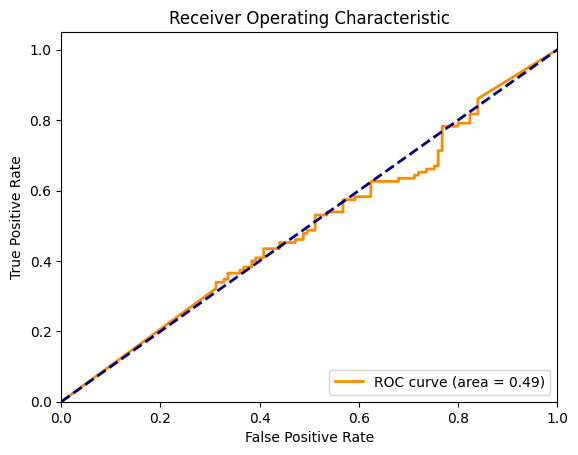

In [200]:
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## All of them

In [201]:


# List of models
models = [log_reg, nb, dtc, rfc, xgb, ada_clf]
model_names = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost']

# Predict the classes for each model
y_preds = [model.predict(X_test) for model in models]

# Calculate and print the F1 score, accuracy, recall, and precision for each model
for i, y_pred in enumerate(y_preds):
    print(f"{model_names[i]}:")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print()

Logistic Regression:
F1 score: 0.6724890829694323
Accuracy: 0.6875
Recall: 0.6695652173913044
Precision: 0.6754385964912281

Naive Bayes:
F1 score: 0.68
Accuracy: 0.6
Recall: 0.8869565217391304
Precision: 0.5513513513513514

Decision Tree:
F1 score: 0.5898617511520737
Accuracy: 0.6291666666666667
Recall: 0.5565217391304348
Precision: 0.6274509803921569

Random Forest:
F1 score: 0.7
Accuracy: 0.75
Recall: 0.6086956521739131
Precision: 0.8235294117647058

XGBoost:
F1 score: 0.7876106194690266
Accuracy: 0.8
Recall: 0.7739130434782608
Precision: 0.8018018018018018

AdaBoost:
F1 score: 0.8
Accuracy: 0.8125
Recall: 0.782608695652174
Precision: 0.8181818181818182



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


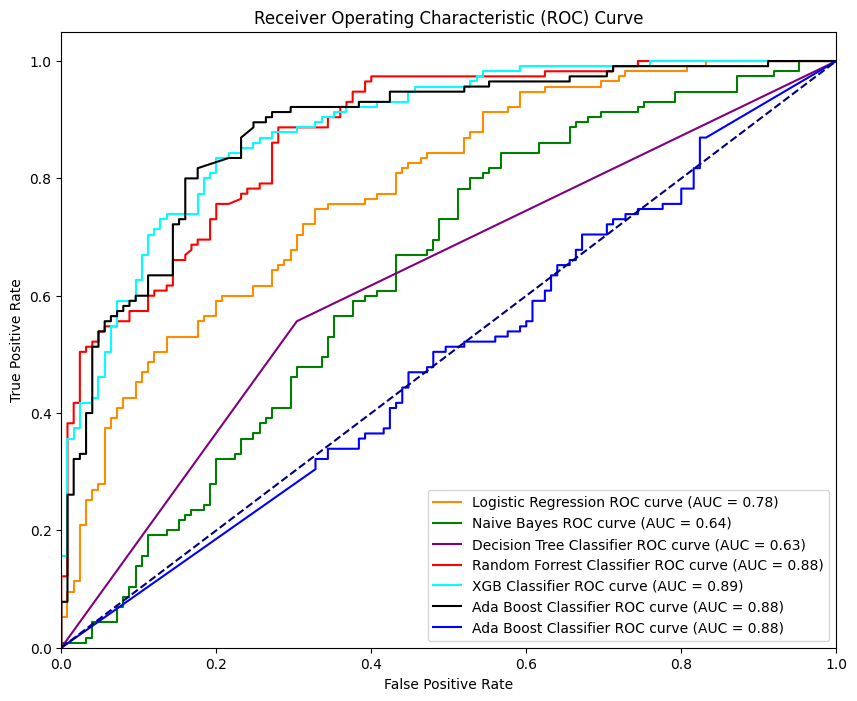

In [202]:


# Compute the probabilities for each model
y_probs1 = log_reg.predict_proba(X_test)[:, 1]
#y_probs2 = sgd_clf.decision_function(X_test)
y_probs3 = nb.predict_proba(X_test)[:, 1]
y_probs4 = dtc.predict_proba(X_test)[:, 1]
y_probs5 = rfc.predict_proba(X_test)[:, 1]
y_probs6 = xgb.predict_proba(X_test)[:, 1]
y_probs7 = ada_clf.predict_proba(X_test)[:, 1]
y_probs8 = nn_seq.predict(dataset_test)

# Compute the ROC curve for each model
fpr1, tpr1, _ = roc_curve(y_test, y_probs1)
#fpr2, tpr2, _ = roc_curve(y_test, y_probs2)
fpr3, tpr3, _ = roc_curve(y_test, y_probs3)
fpr4, tpr4, _ = roc_curve(y_test, y_probs4)
fpr5, tpr5, _ = roc_curve(y_test, y_probs5)
fpr6, tpr6, _ = roc_curve(y_test, y_probs6)
fpr7, tpr7, _ = roc_curve(y_test, y_probs7)
fpr8, tpr8, thresholds = roc_curve(y_test, y_probs8)

# Compute the Area Under the Curve (AUC) score for each model
auc_score1 = roc_auc_score(y_test, y_probs1)
#auc_score2 = roc_auc_score(y_test, y_probs2)
auc_score3 = roc_auc_score(y_test, y_probs3)
auc_score4 = roc_auc_score(y_test, y_probs4)
auc_score5 = roc_auc_score(y_test, y_probs5)
auc_score6 = roc_auc_score(y_test, y_probs6)
auc_score7 = roc_auc_score(y_test, y_probs7)
auc_score8 = auc(fpr8, tpr8)

# Plot the ROC curve for each model
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='darkorange', label=f'Logistic Regression ROC curve (AUC = {auc_score1:.2f})')
#plt.plot(fpr2, tpr2, color='blue', label=f'SGD Classifier ROC curve (AUC = {auc_score2:.2f})')
plt.plot(fpr3, tpr3, color='green', label=f'Naive Bayes ROC curve (AUC = {auc_score3:.2f})')
plt.plot(fpr4, tpr4, color='purple', label=f'Decision Tree Classifier ROC curve (AUC = {auc_score4:.2f})')
plt.plot(fpr5, tpr5, color='red', label=f'Random Forrest Classifier ROC curve (AUC = {auc_score5:.2f})')
plt.plot(fpr6, tpr6, color='cyan', label=f'XGB Classifier ROC curve (AUC = {auc_score6:.2f})')
plt.plot(fpr7, tpr7, color='black', label=f'Ada Boost Classifier ROC curve (AUC = {auc_score7:.2f})')
plt.plot(fpr8, tpr8, color='blue', label=f'Ada Boost Classifier ROC curve (AUC = {auc_score7:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [61]:


# Convert predicted probabilities to class labels
y_pred1 = (y_probs1 > 0.5).astype(int)
y_pred3 = (y_probs3 > 0.5).astype(int)
y_pred4 = (y_probs4 > 0.5).astype(int)
y_pred5 = (y_probs5 > 0.5).astype(int)
y_pred6 = (y_probs6 > 0.5).astype(int)
y_pred7 = (y_probs7 > 0.5).astype(int)

# Calculate and print the F1 score, precision, recall, and accuracy for each model
for i, y_pred in enumerate([y_pred1, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7], start=1):
    print(f"Model {i}:")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print()

Model 1:
F1 score: 0.6949152542372882
Precision: 0.6776859504132231
Recall: 0.7130434782608696
Accuracy: 0.7

Model 2:
F1 score: 0.68
Precision: 0.5513513513513514
Recall: 0.8869565217391304
Accuracy: 0.6

Model 3:
F1 score: 0.5898617511520737
Precision: 0.6274509803921569
Recall: 0.5565217391304348
Accuracy: 0.6291666666666667

Model 4:
F1 score: 0.7
Precision: 0.8235294117647058
Recall: 0.6086956521739131
Accuracy: 0.75

Model 5:
F1 score: 0.7876106194690266
Precision: 0.8018018018018018
Recall: 0.7739130434782608
Accuracy: 0.8

Model 6:
F1 score: 0.8
Precision: 0.8181818181818182
Recall: 0.782608695652174
Accuracy: 0.8125



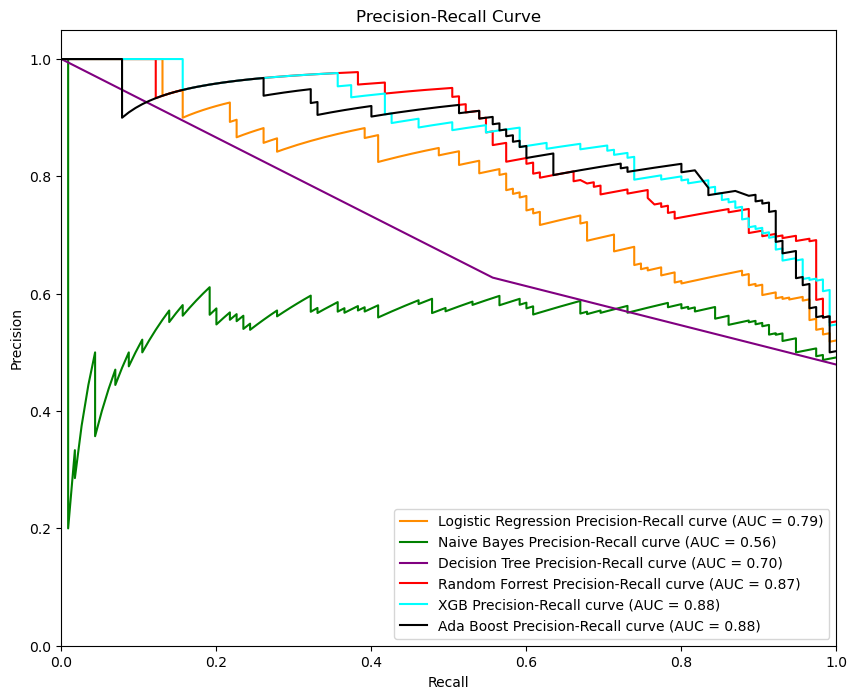

In [62]:


# Compute the probabilities for each model
y_probs1 = log_reg.predict_proba(X_test)[:, 1]
#y_scores2 = sgd_clf.decision_function(X_test)
y_probs3 = nb.predict_proba(X_test)[:, 1]
y_probs4 = dtc.predict_proba(X_test)[:, 1]
y_probs5 = rfc.predict_proba(X_test)[:, 1]
y_probs6 = xgb.predict_proba(X_test)[:, 1]
y_probs7 = ada_clf.predict_proba(X_test)[:, 1]

# Compute the Precision-Recall curve for each model
precision1, recall1, _ = precision_recall_curve(y_test, y_probs1)
#precision2, recall2, _ = precision_recall_curve(y_test, y_scores2)
precision3, recall3, _ = precision_recall_curve(y_test, y_probs3)
precision4, recall4, _ = precision_recall_curve(y_test, y_probs4)
precision5, recall5, _ = precision_recall_curve(y_test, y_probs5)
precision6, recall6, _ = precision_recall_curve(y_test, y_probs6)
precision7, recall7, _ = precision_recall_curve(y_test, y_probs7)

# Compute the Area Under the Curve (AUC) for the Precision-Recall curve for each model
auc_score1 = auc(recall1, precision1)
#auc_score2 = auc(recall2, precision2)
auc_score3 = auc(recall3, precision3)
auc_score4 = auc(recall4, precision4)
auc_score5 = auc(recall5, precision5)
auc_score6 = auc(recall6, precision6)
auc_score7 = auc(recall7, precision7)

# Plot the Precision-Recall curve for each model
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1, color='darkorange', label=f'Logistic Regression Precision-Recall curve (AUC = {auc_score1:.2f})')
#plt.plot(recall2, precision2, color='blue', label=f'SGD Classifier Precision-Recall curve (AUC = {auc_score2:.2f})')
plt.plot(recall3, precision3, color='green', label=f'Naive Bayes Precision-Recall curve (AUC = {auc_score3:.2f})')
plt.plot(recall4, precision4, color='purple', label=f'Decision Tree Precision-Recall curve (AUC = {auc_score4:.2f})')
plt.plot(recall5, precision5, color='red', label=f'Random Forrest Precision-Recall curve (AUC = {auc_score5:.2f})')
plt.plot(recall6, precision6, color='cyan', label=f'XGB Precision-Recall curve (AUC = {auc_score6:.2f})')
plt.plot(recall7, precision7, color='black', label=f'Ada Boost Precision-Recall curve (AUC = {auc_score6:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## Optimisation

In [63]:


# Define the parameter grid to search over
param_grid = {
    'max_depth': [2, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5,0.7, 0.8, 1],
    'objective': ['binary:logistic'],  # Objective for binary classification
    'eval_metric': ['auc']  # Evaluation metrics for binary classification
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',  # You can change this to other metrics such as 'roc_auc', 'f1', etc.
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print the progress
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/Users/pavlospettas/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pavlospettas/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pavlospettas/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/pavlospettas/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected v

[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, objective=binary:logistic, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, objective=binary:logistic, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, objective=binary:logistic, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, objective=binary:logistic, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, objective=binary:logistic, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, objective=binary:logistic, subsample=1; total time=   0.3s
[CV] END colsample_bytree=0.5, eval_metric=auc, gamma=0, learning_rate=0.01, max_depth=3, object

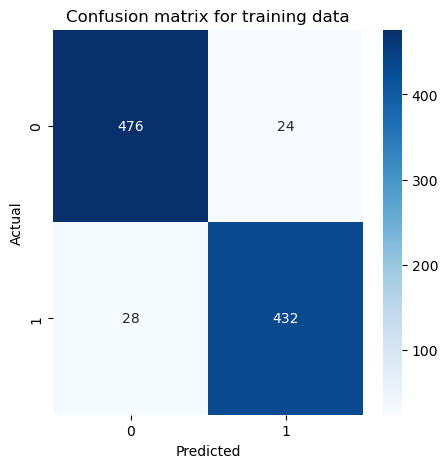

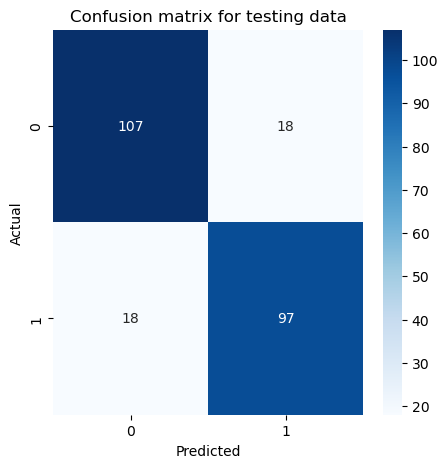

In [64]:
# Retrieve the best parameters
best_params = grid_search.best_params_

# Create a new XGBClassifier with the best parameters
best_xgb_model = XGBClassifier(**best_params)

# Retrain the model on the entire training set
best_xgb_model.fit(X_train, y_train)

# Predict the classes for both training and testing data
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

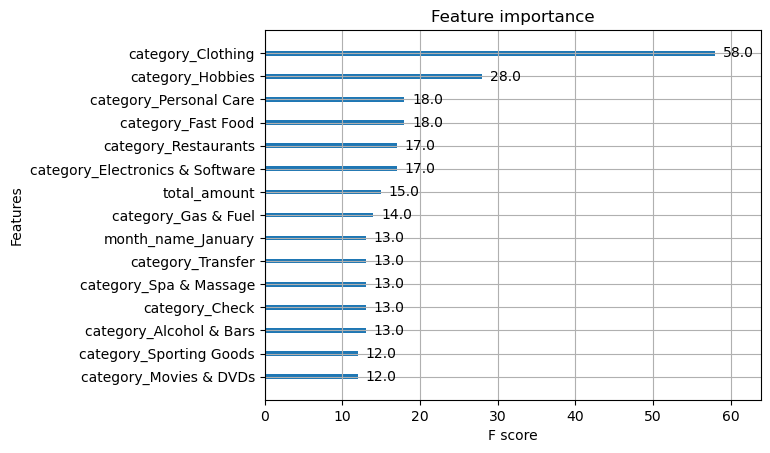

In [65]:
import xgboost as xgb

# Plot feature importance for top 15 features
xgb.plot_importance(best_xgb_model, max_num_features=15)
plt.show()

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create the RandomForestClassifier object
rf = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  # You can change this to other metrics such as 'accuracy', 'f1', etc.
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print the progress
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim

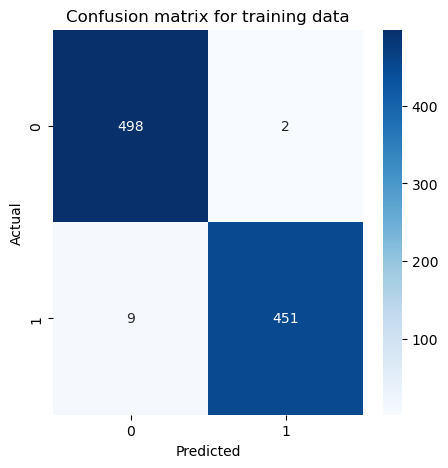

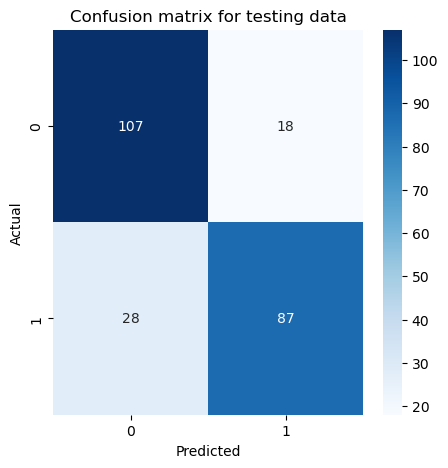

In [67]:
# Retrieve the best parameters
best_params = grid_search.best_params_

# Create a new XGBClassifier with the best parameters
best_rf_model = RandomForestClassifier(**best_params)

# Retrain the model on the entire training set
best_rf_model.fit(X_train, y_train)

# Predict the classes for both training and testing data
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

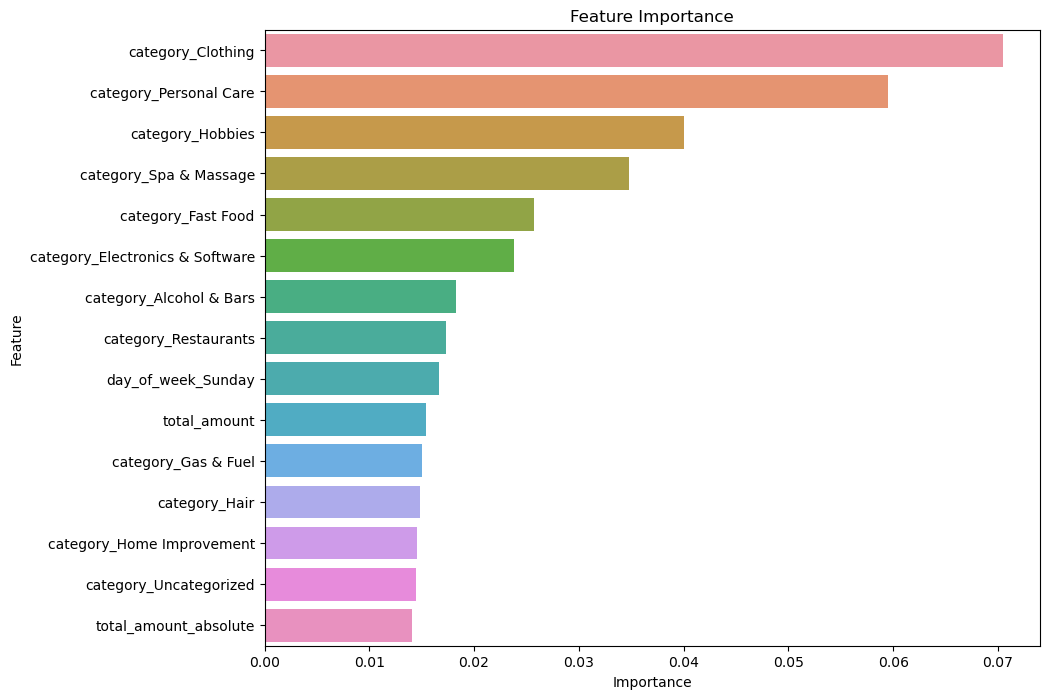

In [68]:


# Assuming best_rf_model is your trained RandomForestClassifier
importances = best_rf_model.feature_importances_

# Create a DataFrame for feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importance for top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Feature Importance')
plt.show()

In [69]:


# Define the parameter grid to search over
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=d) for d in range(1, 5)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# Create the AdaBoostClassifier object with a Decision Tree base estimator
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    scoring='roc_auc',  # You can change this to other metrics such as 'accuracy', 'f1', etc.
    cv=3,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print the progress
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.01, n_estimators=50; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=50; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=50; total time=   0.2s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.01, n_estimators=100; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.01, n_estimators=100; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=0.1, n_estimators=50; total time=   0.2s
[CV

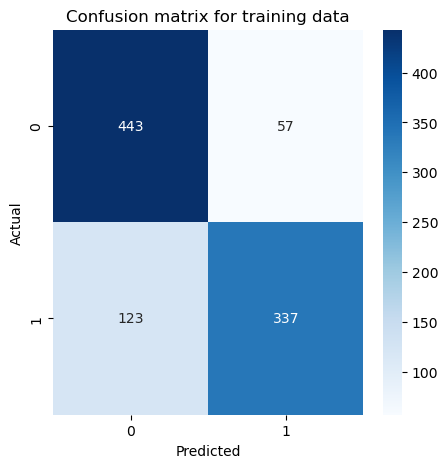

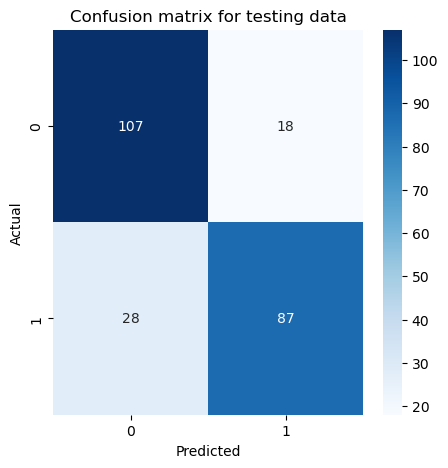

In [70]:
# Retrieve the best parameters
best_params = grid_search.best_params_

# Create a new AdaBoostClassifier with the best parameters
best_ada_model = AdaBoostClassifier(**best_params)

# Retrain the model on the entire training set
best_ada_model.fit(X_train, y_train)

# Predict the classes for both training and testing data
y_train_pred = best_ada_model.predict(X_train)
y_test_pred = best_ada_model.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

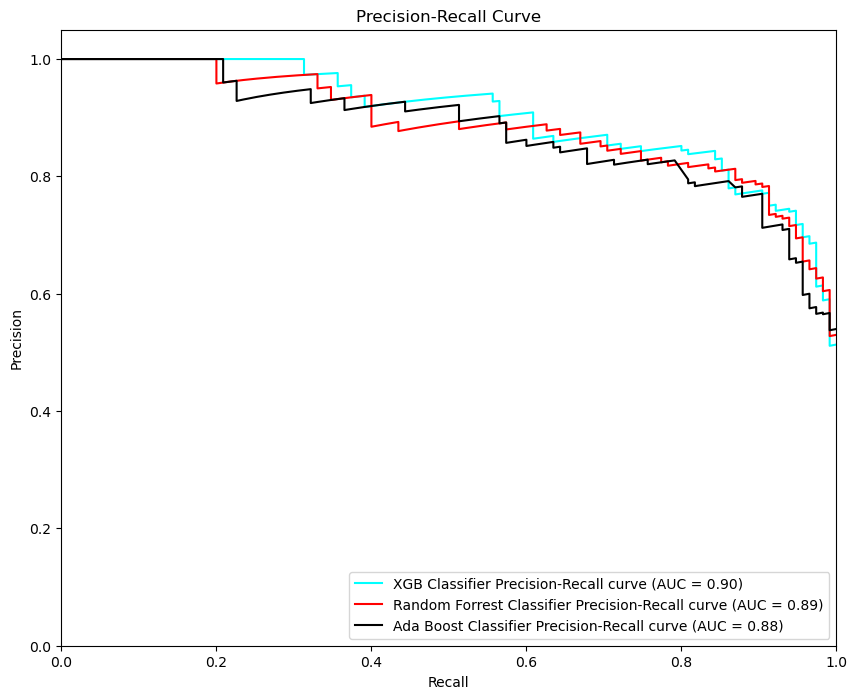

In [71]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute the probabilities for each model
y_probs1 = best_xgb_model.predict_proba(X_test)[:, 1]
y_probs2 = best_rf_model.predict_proba(X_test)[:, 1]
y_probs3 = best_ada_model.predict_proba(X_test)[:, 1]

# Compute the Precision-Recall curve for each model
precision1, recall1, _ = precision_recall_curve(y_test, y_probs1)
precision2, recall2, _ = precision_recall_curve(y_test, y_probs2)
precision3, recall3, _ = precision_recall_curve(y_test, y_probs3)

# Compute the Area Under the Curve (AUC) for the Precision-Recall curve for each model
auc_score1 = auc(recall1, precision1)
auc_score2 = auc(recall2, precision2)
auc_score3 = auc(recall3, precision3)

# Plot the Precision-Recall curve for each model
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1, color='cyan', label=f'XGB Classifier Precision-Recall curve (AUC = {auc_score1:.2f})')
plt.plot(recall2, precision2, color='red', label=f'Random Forrest Classifier Precision-Recall curve (AUC = {auc_score2:.2f})')
plt.plot(recall3, precision3, color='black', label=f'Ada Boost Classifier Precision-Recall curve (AUC = {auc_score3:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [72]:
# Compute the Precision-Recall curve and thresholds for each model
precision1, recall1, thresholds1 = precision_recall_curve(y_test, y_probs1)
precision2, recall2, thresholds2 = precision_recall_curve(y_test, y_probs2)

# Find the last threshold where the precision is at least 80% for each model
threshold_80_precision1 = thresholds1[np.argmax(precision1 >= 0.80)]
threshold_80_precision2 = thresholds2[np.argmax(precision2 >= 0.80)]

print(f"Threshold for XGB Classifier to achieve at least 80% precision: {threshold_80_precision1}")
print(f"Threshold for Random Forest Classifier to achieve at least 80% precision: {threshold_80_precision2}")

Threshold for XGB Classifier to achieve at least 80% precision: 0.45082008838653564
Threshold for Random Forest Classifier to achieve at least 80% precision: 0.45874584816246605


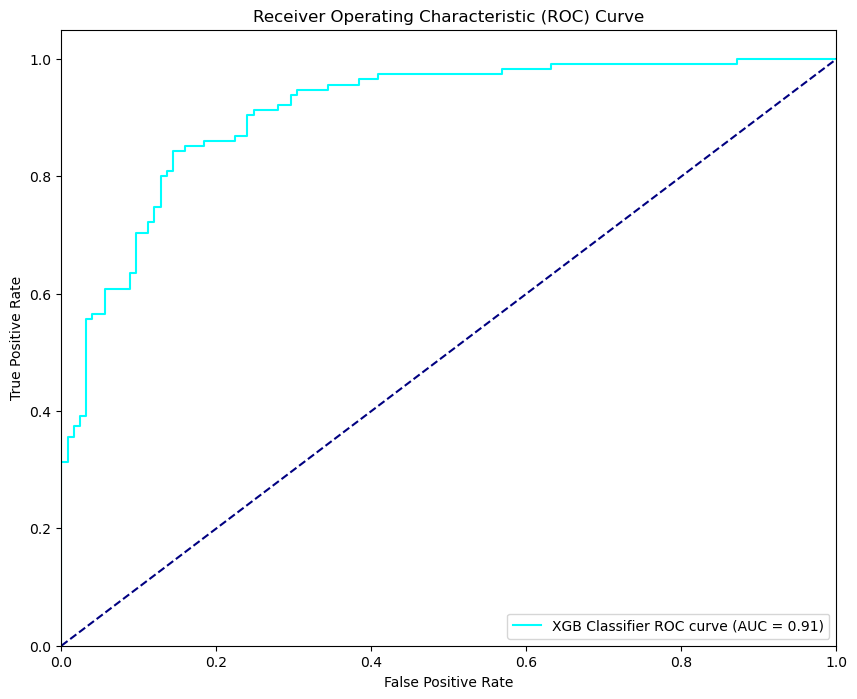

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute the probabilities for each model
y_probs1 = best_xgb_model.predict_proba(X_test)[:, 1]
#y_probs2 = best_rf_model.predict_proba(X_test)[:, 1]
#y_probs3 = best_ada_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve for each model
fpr1, tpr1, _ = roc_curve(y_test, y_probs1)
#fpr2, tpr2, _ = roc_curve(y_test, y_probs2)
#fpr3, tpr3, _ = roc_curve(y_test, y_probs3)

# Compute the Area Under the Curve (AUC) score for each model
auc_score1 = roc_auc_score(y_test, y_probs1)
#auc_score2 = roc_auc_score(y_test, y_probs2)
#auc_score3 = roc_auc_score(y_test, y_probs3)

# Plot the ROC curve for each model
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='cyan', label=f'XGB Classifier ROC curve (AUC = {auc_score1:.2f})')
#plt.plot(fpr2, tpr2, color='red', label=f'Random Forrest Classifier ROC curve (AUC = {auc_score2:.2f})')
#plt.plot(fpr3, tpr3, color='black', label=f'Ada Boost Classifier ROC curve (AUC = {auc_score3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [74]:


# Predict the classes for the test set
y_test_pred1 = best_xgb_model.predict(X_test)
y_test_pred2 = best_rf_model.predict(X_test)

# Get the classification report for the first classifier
report1 = classification_report(y_test, y_test_pred1)

# Get the classification report for the second classifier
report2 = classification_report(y_test, y_test_pred2)

print("Classifier 1 metrics:\n", report1)
print("Classifier 2 metrics:\n", report2)

Classifier 1 metrics:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       125
           1       0.84      0.84      0.84       115

    accuracy                           0.85       240
   macro avg       0.85      0.85      0.85       240
weighted avg       0.85      0.85      0.85       240

Classifier 2 metrics:
               precision    recall  f1-score   support

           0       0.79      0.86      0.82       125
           1       0.83      0.76      0.79       115

    accuracy                           0.81       240
   macro avg       0.81      0.81      0.81       240
weighted avg       0.81      0.81      0.81       240



In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Predict the classes for the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate and print the precision, recall, F1 score, and accuracy
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 score: ", f1_score(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Precision:  0.8434782608695652
Recall:  0.8434782608695652
F1 score:  0.8434782608695653
Accuracy:  0.85


## Voting Classifier

In [76]:
# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb_model), ('rf', best_rf_model), ('ada', best_ada_model)],
    voting='soft'
)

# Fit the voting classifier to the training data
voting_clf.fit(X_train, y_train)

# Perform cross-validation on the test set
scores = cross_val_score(voting_clf, X_test, y_test, cv=5,scoring='recall')

print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.7826087  0.7826087  0.73913043 0.65217391 0.69565217]
Mean cross-validation score: 0.7304347826086957


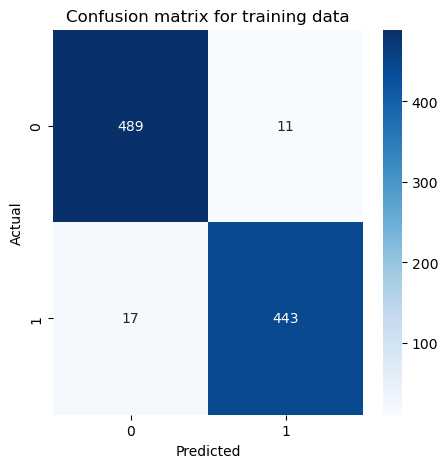

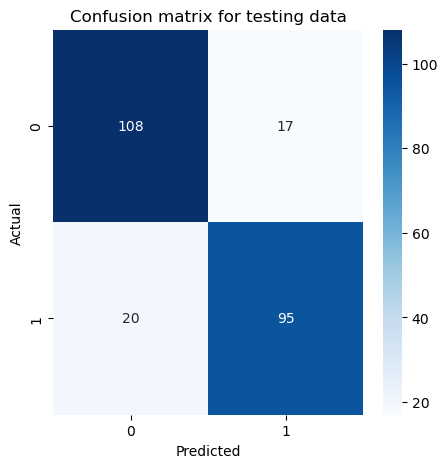

In [77]:


# Predict the classes for both training and testing data
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

# Compute the confusion matrix for both training and testing data
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a function to plot the confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot the confusion matrix for both training and testing data
plot_confusion_matrix(cm_train, 'Confusion matrix for training data')
plot_confusion_matrix(cm_test, 'Confusion matrix for testing data')

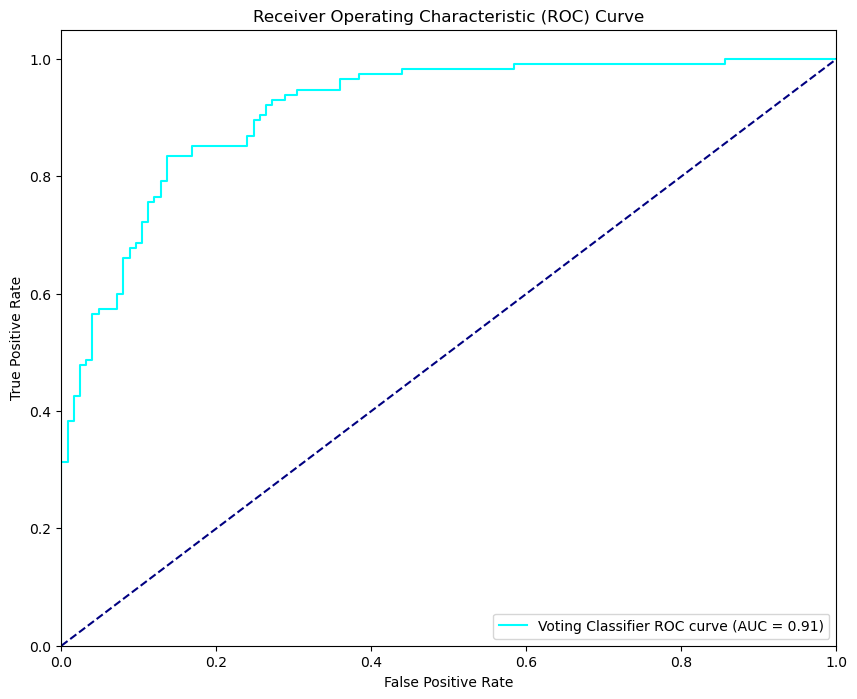

In [78]:


# Compute the probabilities for each model
y_probs1 = voting_clf.predict_proba(X_test)[:, 1]
#y_probs2 = best_rf_model.predict_proba(X_test)[:, 1]
#y_probs3 = best_ada_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve for each model
fpr1, tpr1, _ = roc_curve(y_test, y_probs1)
#fpr2, tpr2, _ = roc_curve(y_test, y_probs2)
#fpr3, tpr3, _ = roc_curve(y_test, y_probs3)

# Compute the Area Under the Curve (AUC) score for each model
auc_score1 = roc_auc_score(y_test, y_probs1)
#auc_score2 = roc_auc_score(y_test, y_probs2)
#auc_score3 = roc_auc_score(y_test, y_probs3)

# Plot the ROC curve for each model
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, color='cyan', label=f'Voting Classifier ROC curve (AUC = {auc_score1:.2f})')
#plt.plot(fpr2, tpr2, color='red', label=f'Random Forrest Classifier ROC curve (AUC = {auc_score2:.2f})')
#plt.plot(fpr3, tpr3, color='black', label=f'Ada Boost Classifier ROC curve (AUC = {auc_score3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Model Extraction

In [79]:
import pickle

# Save the model to a file in the current directory
with open('model.bin', 'wb') as file:
    pickle.dump(best_xgb_model, file)